# Thought For Food: Providing Qaulity Recipe Recommendations to the Burgeoning Cook

James Ades, Aidan Keogh, Zach Wallace

In this notebook we provide the EDA, data preparation, modeling, results, and evalutation of our recipe recommender system using user-recipe rating data from food.com.

# Part 1: Data Loading and EDA

In [5]:
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import pandas as pd
import numpy as np
import pickle

In [2]:
pp_recipes = dd.read_csv('data/PP_recipes.csv')
raw_recipes = dd.read_csv('data/RAW_recipes.csv')
pp_users = dd.read_csv('data/PP_users.csv')
raw_inter = dd.read_csv('data/RAW_interactions.csv')
inter_train = dd.read_csv('data/interactions_train.csv')
with open('data/ingr_map.pkl', 'rb') as handle:
    ingr_map = pickle.load(handle)

NOTE: The providers of our data offered mulitle datasets. The RAW_interactions data is the raw data for user-recipe ratings and the RAW_recipes data is the raw data for recipes with ingredients.  We primarily care about the user-recipe rating data for building matrix factorization models as desribed downstream.  The othe data are processed versions of the rating and recipe data and the ingr_map provides a tokenized dataset for the recipes

## Checking Out Recipes Data

In [4]:
print("Length of the raw_recipes", len(raw_recipes))
raw_recipes.head()

Length of the raw_recipes 231637


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [6]:
print("Length of ingr_map", len(ingr_map))
ingr_map.head()

Length of ingr_map 11659


,raw_ingr,raw_words,processed,len_proc,replaced,count,id
0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308
1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308
2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308
3,iceberg lettuce leaf,3,iceberg lettuce leaf,20,lettuce,4507,4308
4,red romaine lettuce,3,red romaine lettuce,19,lettuce,4507,4308


NOTE: The ingr_map had processed all the ingredients and tokenized them to a more concise label

## Checking Out User-Recipes Ratings Data

In [8]:
print("Length of raw_interactions", len(raw_inter))
raw_inter.head()

Length of raw_interactions 1132367


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [9]:
print("Lenth of interactions_train", len(inter_train))
inter_train.head()

Lenth of interactions_train 698901


,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


## EDA

### Distribution of ratings per user: raw data

In [10]:
import matplotlib.pyplot as plt
import ast
plt.rcParams["figure.figsize"] = (8,6)

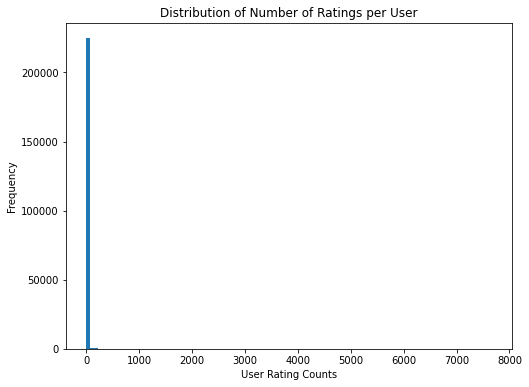

count    226570.000000
mean          4.997868
std          49.663111
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max        7671.000000
dtype: float64

In [12]:
user_rating_counts = raw_inter.groupby(by = ['user_id']).size().compute()
plt.hist(user_rating_counts, bins = 100)
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("User Rating Counts")
plt.ylabel("Frequency")
plt.show()
user_rating_counts = dd.from_array(user_rating_counts)
user_rating_counts.describe().compute()

### Distribution of ratings per recipe: raw data

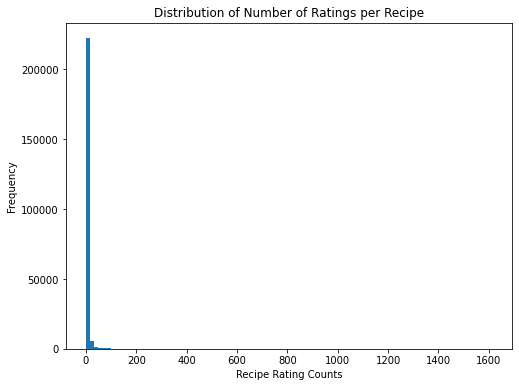

count    231637.000000
mean          4.888541
std          17.532481
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1613.000000
dtype: float64

In [13]:
recipe_rating_counts = raw_inter.groupby(by = ['recipe_id']).size().compute()
plt.hist(recipe_rating_counts, bins = 100)
plt.title("Distribution of Number of Ratings per Recipe")
plt.xlabel("Recipe Rating Counts")
plt.ylabel("Frequency")
plt.show()
recipe_rating_counts = dd.from_array(recipe_rating_counts)
recipe_rating_counts.describe().compute()

### Distribution of mean rating per user: raw data

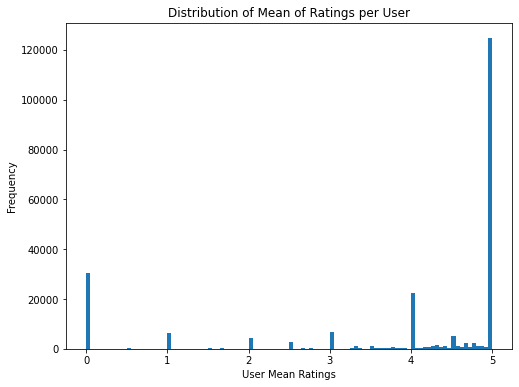

count    226570.000000
mean          3.873031
std           1.773173
min           0.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
dtype: float64

In [14]:
user_rating_means = raw_inter.groupby(by = ['user_id'])['rating'].mean().compute()
plt.hist(user_rating_means, bins = 100)
plt.title("Distribution of Mean of Ratings per User")
plt.xlabel("User Mean Ratings")
plt.ylabel("Frequency")
plt.show()
user_rating_means = dd.from_array(user_rating_means)
user_rating_means.describe().compute()

### Distribution of mean rating per recipe: raw data

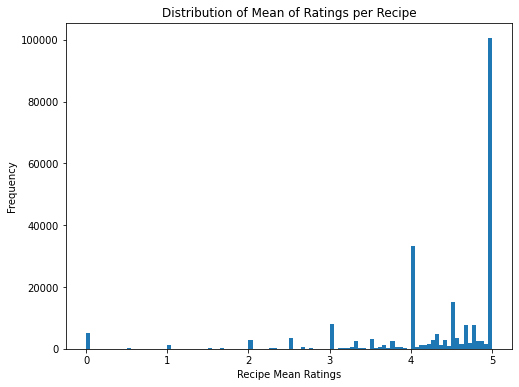

count    231637.000000
mean          4.346246
std           0.990806
min           0.000000
25%           4.000000
50%           4.833333
75%           5.000000
max           5.000000
dtype: float64

In [15]:
recipe_rating_means = raw_inter.groupby(by = ['recipe_id'])['rating'].mean().compute()
plt.hist(recipe_rating_means, bins = 100)
plt.title("Distribution of Mean of Ratings per Recipe")
plt.xlabel("Recipe Mean Ratings")
plt.ylabel("Frequency")
plt.show()
recipe_rating_means = dd.from_array(recipe_rating_means)
recipe_rating_means.describe().compute()

### Distribution of Ratings: raw data

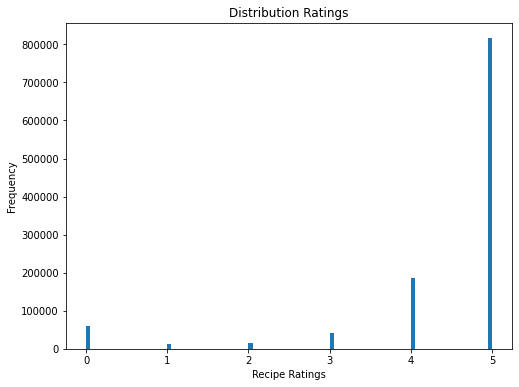

,0
count,1.132367e+06
mean,4.411016e+00
std,1.264752e+00
min,0.000000e+00
25%,4.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


In [16]:
recipe_ratings = list(raw_inter['rating'])
plt.hist(recipe_ratings, bins = 100)
plt.title("Distribution Ratings")
plt.xlabel("Recipe Ratings")
plt.ylabel("Frequency")
plt.show()
recipe_ratings = pd.DataFrame(recipe_ratings)
recipe_ratings.describe()

### Some exploring of "interactions_train" data

In [17]:
print("The total amount of user-recipe ratings in train", len(inter_train))
print("The total amount of users in the user-recipe ratings train", len(inter_train.drop_duplicates(subset = ['user_id'])))
print("The total amount of recipes in the user-recipe ratings train", len(inter_train.drop_duplicates(subset = ['recipe_id'])))

The total amount of user-recipe ratings in train 698901
The total amount of users in the user-recipe ratings train 25076
The total amount of recipes in the user-recipe ratings train 160901


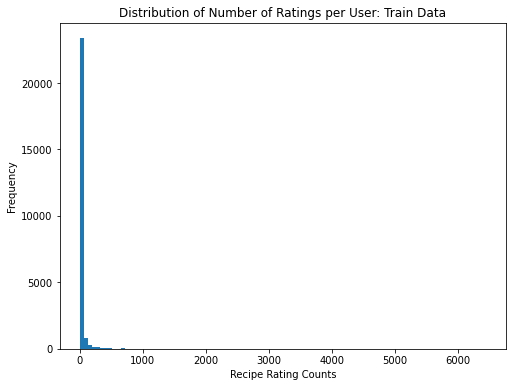

count    25076.000000
mean        27.871311
std        122.729039
min          2.000000
25%          3.000000
50%          6.000000
75%         16.000000
max       6437.000000
dtype: float64

In [18]:
user_rating_counts = inter_train.groupby(by = ['user_id']).size().compute()
plt.hist(user_rating_counts, bins = 100)
plt.title("Distribution of Number of Ratings per User: Train Data")
plt.xlabel("Recipe Rating Counts")
plt.ylabel("Frequency")
plt.show()
user_rating_counts = dd.from_array(user_rating_counts)
user_rating_counts.describe().compute()

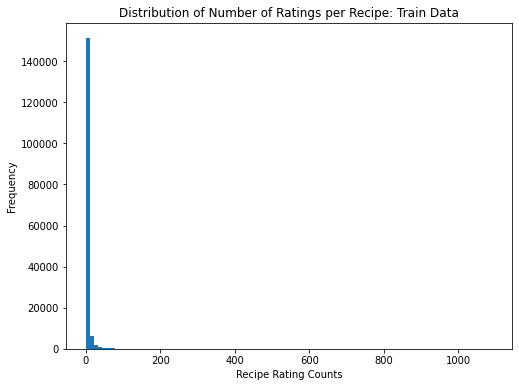

count    160901.000000
mean          4.343671
std          13.421461
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max        1091.000000
dtype: float64

In [19]:
recipe_rate_counts = inter_train.groupby(by = ['recipe_id']).size().compute()
plt.hist(recipe_rate_counts, bins = 100)
plt.title("Distribution of Number of Ratings per Recipe: Train Data")
plt.xlabel("Recipe Rating Counts")
plt.ylabel("Frequency")
plt.show()
recipe_rate_counts = dd.from_array(recipe_rate_counts)
recipe_rate_counts.describe().compute()

CONCLUSION OF EDA: It appears the supplied "interactions_train.csv" is already a cleaned version of the raw_interactions data, but since it still has outliers rating counts and recipes that only recieved one rating, we are going to provide our own quality control and clean the raw_interactions data ourselves.

# Part 2: Data Preparation

### Using that Information from EDA to clean the user-recipe interactions dataset

What we will throw out ...

(1) Users that rated more than 100 recipes and less than 4

(2) Users that had an average rating of less than 2.5

(3) Recipes that had less than 2 ratings

(4) Recipes that had an average rating less than 2.5

In [21]:
user_rating_counts = raw_inter.groupby(by = ['user_id']).size().compute()
user_rating_means = raw_inter.groupby(by = ['user_id'])['rating'].mean().compute()
recipe_rating_counts = raw_inter.groupby(by = ['recipe_id']).size().compute()
recipe_rating_means = raw_inter.groupby(by = ['recipe_id'])['rating'].mean().compute()

First looking at the total amount of users, total amount of recipes, and total interactions in the user-recipe rating dataset

In [23]:
print("The total amount of user-recipe ratings", len(raw_inter))
print("The total amount of users in the user-recipe ratings", len(raw_inter.drop_duplicates(subset = ['user_id'])))
print("The total amount of recipes in the user-recipe ratings", len(raw_inter.drop_duplicates(subset = ['recipe_id'])))

The total amount of user-recipe ratings 1132367
The total amount of users in the user-recipe ratings 226570
The total amount of recipes in the user-recipe ratings 231637


Cleaning and examining how much the raw interactions dataset get preserved when throwing out data

In [24]:
good_users1 = user_rating_counts[(user_rating_counts <= 100) & (user_rating_counts >= 4)]
good_users2 = user_rating_means[user_rating_means >= 2.5]
good_users = good_users1.index.intersection(good_users2.index)
good_user_ids = [user_id for user_id in good_users]

good_recipes1 = recipe_rating_counts[(recipe_rating_counts >= 2)]
good_recipes2 = recipe_rating_means[recipe_rating_means >= 2.5]
good_recipes = good_recipes1.index.intersection(good_recipes2.index)
good_recipe_ids = [recipe_id for recipe_id in good_recipes]

raw_inter_cleaned = raw_inter[(raw_inter['user_id'].isin(good_user_ids)) & (raw_inter['recipe_id'].isin(good_recipe_ids))]
raw_inter_cleaned = raw_inter_cleaned.drop(columns = ['date', 'review'])
raw_inter_cleaned = raw_inter_cleaned.dropna()

print("The total amount of clean user-recipe ratings", len(raw_inter_cleaned))
print("The total amount of clean users in the user-recipe ratings", len(raw_inter_cleaned.drop_duplicates(subset = ['user_id'])))
print("The total amount of clean recipes in the user-recipe ratings", len(raw_inter_cleaned.drop_duplicates(subset = ['recipe_id'])))

The total amount of clean user-recipe ratings 353281
The total amount of clean users in the user-recipe ratings 26329
The total amount of clean recipes in the user-recipe ratings 87595


Convert the cleaned interactions dask dataframe to pandas and save as a CSV. This will be loaded into a pyspark or dask dataframe later for creating the recommender system

In [25]:
raw_inter_cleaned = raw_inter_cleaned.compute()
raw_inter_cleaned.to_csv("data/interactions_train_cleaned.csv", index = False)

# Part 3: Recipe Recommender Modeling

This runs the recommender models on the cleaned user-recipes interactions datasets and applies the various evaluation metrics for evaluating the results of our recommendations.

### Start Spark Session

In [1]:
# Code from https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html
import pyspark
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


conf = pyspark.SparkConf().setAll([('spark.master', 'local[2]'),
                                   ('spark.app.name', 'Recommender Results')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-26 20:56:52,658 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read in cleaned user-recipes interactions data frame

In [2]:
file_path = 'file:///home/work/data/interactions_train_cleaned.csv'
ratings = spark.read.csv(file_path, inferSchema = True, header = True)
ratings.show()

+-------+---------+------+
|user_id|recipe_id|rating|
+-------+---------+------+
|  38094|    40893|     4|
|1293707|    40893|     5|
| 190375|   134728|     5|
|1171894|   134728|     5|
| 217118|   200236|     5|
| 202555|   225241|     5|
| 684460|   225241|     5|
| 135017|   254596|     5|
| 224088|   254596|     4|
| 582223|   254596|     5|
| 935485|   321038|     5|
| 102602|    20930|     5|
| 172467|    29093|     5|
|  58332|    41090|     4|
| 160497|    41090|     5|
| 183565|    79222|     5|
| 349752|    79222|     5|
| 226989|    79222|     4|
| 868654|    79222|     5|
| 302867|    79222|     5|
+-------+---------+------+
only showing top 20 rows



### Random split and normalize training and testing

In [3]:
(unnorm_training, unnorm_test) = ratings.randomSplit([0.8, 0.2])
mean = unnorm_training.agg({'rating': 'mean'}).collect()[0][0]
std = unnorm_training.agg({'rating': 'std'}).collect()[0][0]
print(mean, std)
training = unnorm_training.withColumn("rating", (col("rating") - mean) / std)
test = unnorm_test.withColumn("rating", (col("rating") - mean) / std)

4.528296282676417 1.0749342175231047


## (3a) Modeling With the ALS Collaborative Filtering, pyspark

This was our first model that we tried out for building the recommender system.  It take the user-recipe rating data and build and ALS collaborative filtering model to predict the rating a user will give a recipe.  The predicted ratings can be used for choosing recommendations

### Generate recipe recommendations with the collaborative filtering model and evaluate with RMSE

Fit collaborative filtering model

In [4]:
# Setting cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(rank=200, maxIter=20, regParam=0.125, userCol="user_id", itemCol="recipe_id", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

2022-05-26 20:57:26,122 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
2022-05-26 20:57:26,126 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
2022-05-26 20:57:26,875 WARN netlib.InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Evaluate model with MSE

In [5]:
normalized_predictions = model.transform(test)
predictions = normalized_predictions.withColumn(
    "rating",col("rating") * std + mean
).withColumn(
    "prediction",col("prediction") * std + mean
)
evaluator = RegressionEvaluator(metricName="mse", labelCol="rating",
                                predictionCol="prediction")

mse = evaluator.evaluate(predictions)
print("The MSE of the recommender model is", mse)
predictions.show()

The MSE of the recommender model is 1.1653953509773878


+-------+---------+------+------------------+
|user_id|recipe_id|rating|        prediction|
+-------+---------+------+------------------+
| 269153|       81|   5.0| 4.602834605888442|
| 194829|       91|   5.0|  4.69349830451431|
| 983811|       94|   5.0| 4.560909103137501|
| 242779|      112|   4.0| 4.372207505898415|
| 985729|      120|   5.0| 4.541292287770022|
| 210805|      120|   4.0|4.5235986752559985|
| 244432|      120|   5.0| 4.712666014702365|
| 797995|      142|   5.0|  4.47969147076047|
| 121354|      142|   2.0| 4.537968124371443|
| 914114|      142|   4.0| 4.692453817895429|
|1386579|      142|   5.0| 4.668417234807098|
| 983723|      185|   5.0| 4.551251476210506|
| 804978|      191|   5.0|4.6429283126809615|
|  91326|      192|   4.0| 4.555030978703609|
|  94740|      192|   5.0|  4.63869515295898|
| 126469|      192|   5.0| 4.595370566244551|
|  91724|      197|   5.0| 4.366695663770921|
|  27452|      210|   5.0| 4.576294329525376|
| 340099|      232|   5.0|  4.6698

## Evaluation Metrics

We will load in the RecEvalMetrics object and thoroughly evaluate the recipe recommender system with various evaluation metrics.

In [3]:
pip install rbo

Note: you may need to restart the kernel to use updated packages.


In [4]:
# !pip install rbo

from functools import reduce
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, ndcg_score
import pandas as pd
import numpy as np
import rbo

class RecEvalMetrics(object):


    # Takes user-recipe rating predictions dataframe, returns mean squarred error for top k
    # recipes of each user predicted ratings
    """ Parameters:
        predictions: Dataframe of true and predicted ratings, default 20
        k: Top k predicted ratings to evaluate with mse
    """
    @staticmethod
    def top_k_evaluation(predictions, k = 20):
        users = list(predictions.drop_duplicates(subset = ['user_id'])['user_id'])
        top_k_predictions = []
        
        for user in users:
            user_ratings = predictions[(predictions['user_id'] == user)]
            top_k_user_ratings =  user_ratings.sort_values(by = ['prediction'], ascending = False).head(k)
            top_k_predictions.append(top_k_user_ratings)
        top_k_predictions_df = pd.concat(top_k_predictions, ignore_index = True)
        
        k_mse = mean_squared_error(list(top_k_predictions_df['rating']), list(top_k_predictions_df['prediction']))
        
        return(k_mse) 


    # Takes in user-recipe rating predictions dataframe, returns percent of recipes that ended
    # up in someone's top k.  Larger value means more personalization
    """ Parameters:
        predictions: Dataframe of true and predicted ratings
        k: Top k recipes to count in percentage, default 20
    """
    @staticmethod
    def percent_in_top_ratings(predictions, k = 20):
        total_recipes = len(predictions.drop_duplicates(subset = ['recipe_id']))
        users = list(predictions.drop_duplicates(subset = ['user_id'])['user_id'])

        top_k_predictions = set()
        for user in users:
            user_ratings = predictions[(predictions['user_id'] == user)]
            user_pred_ordered = list(user_ratings.sort_values(by = ['prediction'], ascending = False)['recipe_id'])
            top_k_user_recipes = user_pred_ordered[:k]
            top_k_predictions.update(top_k_user_recipes)

        top_recipes_count = len(top_k_predictions)

        return(top_recipes_count/total_recipes)


    # Take in user-recipe rating predictios dataframe, returns ranked biased overlap
    # between top k predicted ratings and top k actual ratings
    # Refer to: https://github.com/changyaochen/rbo
    """ Parametes:
        predictions: Dataframe of true and predicted ratings
        k: Number of k recipes in the ranked list to evaluate with RBO, default 20
    """
    @staticmethod
    def rbo_evaluation(predictions, k = 20):
        users = list(predictions.drop_duplicates(subset = ['user_id'])['user_id'])

        rbos = []
        for user in users:
            user_ratings = predictions[(predictions['user_id'] == user)]
            user_actual_ordered = list(user_ratings.sort_values(by = ['rating'], ascending = False)['recipe_id'])
            user_pred_ordered = list(user_ratings.sort_values(by = ['prediction'], ascending = False)['recipe_id'])
            top_k_user_actual = user_actual_ordered[:k]
            top_k_user_pred = user_pred_ordered[:k]
            user_rbo = rbo.RankingSimilarity(top_k_user_actual, top_k_user_pred).rbo()
            rbos.append(user_rbo)
        
        rbos_describe = pd.DataFrame(rbos)
        return(rbos_describe.describe())


    # Takes in user-recipe rating predictions dataframe, returns the Kendalls Tau evaluation
    # between actual ratings and predicted ratings
    """ Parameters:
        predictions: Dataframe of true and predicted ratings	
    """
    @staticmethod
    def kendalls_tau(predictions):
        users = list(predictions.drop_duplicates(subset = ['user_id'])['user_id'])

        tau = []
        i = 0
        for user in users:
            user_ratings = predictions[(predictions['user_id'] == user)]
            # Kendall's Tau will not work with list of size 1
            if (len(user_ratings) > 1):
                user_actual_ordered = list(user_ratings.sort_values(by = ['rating'], ascending = False)['recipe_id'])
                user_pred_ordered = list(user_ratings.sort_values(by = ['prediction'], ascending = False)['recipe_id'])
                user_tau, user_p_value = kendalltau(user_actual_ordered, user_pred_ordered)
                tau.append(user_tau)
    
        tau_describe = pd.DataFrame(tau)
        return(tau_describe.describe())


    # Takes in user-recipe rating predictions dataframe, returns the normalized discounted cummulative gain
    # evaluation between actual ratings and predicted ratings
    """ Parameters:
        predictions: Dataframe of ture and predicted ratings
        k: Number of k recipes in the ranked list to evaluate, default None	
    """
    @staticmethod
    def nDCG_evaluation(predictions, k = None):
        users = list(predictions.drop_duplicates(subset = ['user_id'])['user_id'])

        ndcg = []
        for user in users:
            user_ratings = predictions[(predictions['user_id'] == user)]
            if (len(user_ratings) > 1):
                relevance = np.asarray([list(user_ratings['rating'])])
                preds = np.asarray([list(user_ratings['prediction'])])
                score = ndcg_score(relevance, preds, k=k)
                ndcg.append(score)
        
        ndcg_describe = pd.DataFrame(ndcg)
        return(ndcg_describe.describe())
    
    # Takes in user-recipe rating predictions dataframe, returns the Spearman Rank Correlation
    # evaluation between actual ratings and predicted ratings
    """ Parameters:
        predictions: Dataframe of ture and predicted ratings
    """
    @staticmethod
    def spearman_evaluation(predictions, k = None):
        users = list(predictions.drop_duplicates(subset = ['user_id'])['user_id'])

        rhos = []
        for user in users:
            user_ratings = predictions[(predictions['user_id'] == user)]
            if (len(user_ratings) > 1):
                ratings = np.asarray(user_ratings['rating'])
                preds = np.asarray(user_ratings['prediction'])
                rho, pval = spearmanr(ratings, preds)
                rhos.append(rho)
        
        rho_describe = pd.DataFrame(rhos)
        return(rho_describe.describe())

Conver the predictions pyspark dataframe to a pandas dataframe for feeding into metrics evaluations. NOTE: We're doing this to keep the eval_metrics object generalized so that it could also accept dask results following conversion

In [8]:
predictions_df = predictions.toPandas()

### Top 10 MSE

In [9]:
k_mse = RecEvalMetrics.top_k_evaluation(predictions_df, 10)
print("The top 10 MSE:", k_mse)

The top 10 MSE: 1.1704301836355948


### Percent in top 10 (Personalization Assessment)

In [10]:
percent_in_top = RecEvalMetrics.percent_in_top_ratings(predictions_df, 10)
print("The percent of recipes that are in some users top 10:", percent_in_top)

The percent of recipes that are in some users top 10: 0.9667492451807695


### Ranked Biased Overlap, top 10

In [11]:
rbo_summary = RecEvalMetrics.rbo_evaluation(predictions_df, 10)
print(rbo_summary)

                  0
count  19689.000000
mean       0.789514
std        0.237714
min        0.074722
25%        0.500000
50%        1.000000
75%        1.000000
max        1.000000


### Kendall's Tau

In [12]:
kendalls_tau_summary = RecEvalMetrics.kendalls_tau(predictions_df)
print(kendalls_tau_summary)

                  0
count  12307.000000
mean       0.022708
std        0.719843
min       -1.000000
25%       -0.523810
50%        0.000000
75%        0.666667
max        1.000000


### Normalized Discounted Cummulative Gain

In [13]:
ndcg_summary = RecEvalMetrics.nDCG_evaluation(predictions_df, 10)
print(ndcg_summary)

                  0
count  12307.000000
mean       0.968341
std        0.072958
min        0.000000
25%        0.962559
50%        1.000000
75%        1.000000
max        1.000000


### Spearman Rank Correlation

In [14]:
spearman_summary = RecEvalMetrics.spearman_evaluation(predictions_df)
print(spearman_summary)

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


                 0
count  6546.000000
mean      0.024474
std       0.679178
min      -1.000000
25%      -0.518637
50%       0.000000
75%       0.632456
max       1.000000


## (3b) Modeling with the Similarity Scorer and Averaging, dask

This uses an alternative approach to predicting user ratings through similarity scoring metrics and includes different types of rating averaging for baseline evaluation.  This part is done in dask.

In [5]:
pip install sparse

     |████████████████████████████████| 77 kB 6.1 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [1]:
import dask
import dask.array as da
import dask.dataframe as dd
import sparse
import dask_ml
import time

import numpy as np
import pandas as pd

from dask.distributed import Client
client = Client(memory_limit='6GB')

2022-05-26 00:20:47,486 - distributed.diskutils - INFO - Found stale lock file and directory '/home/work/dask-worker-space/worker-1k2guxok', purging
2022-05-26 00:20:47,496 - distributed.diskutils - INFO - Found stale lock file and directory '/home/work/dask-worker-space/worker-ab10wnq0', purging
2022-05-26 00:20:47,509 - distributed.diskutils - INFO - Found stale lock file and directory '/home/work/dask-worker-space/worker-k8nzx1qj', purging


In [2]:
seed = 25
ddf = dd.read_csv("data/interactions_train_cleaned.csv")
train, val = dask_ml.model_selection.train_test_split(ddf, test_size=0.1, train_size=0.9,shuffle=True,random_state=seed)
print(len(train), len(val))

308015 34001


### Using Averages as Predicted Ratings:

Computing rating average and rating standard deviation ...

In [3]:
rating_avg = train.rating.mean().compute()
rating_std = train.rating.std().compute()
print(rating_avg, rating_std)

4.671889356037855 0.7121078429179404


### Baseline 1: Predict using global average rating among all users

How well would a model perform with just rating averages as predictions?

In [4]:
val["prediction"] = rating_avg
print(dask_ml.metrics.mean_squared_error(val.rating.to_dask_array(), val.prediction.to_dask_array()))

0.5169555594737777


### Baseline 2: Predict using average rating for each user

In [5]:
user_avgs = train.groupby("user_id").rating.mean().compute()
val["prediction"] = val.user_id.apply(
    lambda x: user_avgs[x] if x in user_avgs else rating_avg, 
    meta=('user_id', 'int64')
)
print(dask_ml.metrics.mean_squared_error(val.rating.to_dask_array(), val.prediction.to_dask_array()))

0.4964676076844779


### Baseline 3: Predict using average rating for each user, bayesian style

In [6]:
bayesian_df = pd.DataFrame()
user_avgs = train.groupby("user_id").rating.mean().compute()
user_counts = train.groupby("user_id").rating.count().compute()
k = 6
val["personal_rating"] = val.user_id.apply(
    lambda x: (rating_avg * k + user_avgs[x] * user_counts[x]) / (user_counts[x] + k) if x in user_avgs else rating_avg, 
    meta=('personal_rating', 'float32')
)
err = dask_ml.metrics.mean_squared_error(val.rating.to_dask_array(), val.personal_rating.to_dask_array())
bayesian_df = bayesian_df.append({"k": k, "err": err}, ignore_index=True)
print(bayesian_df)

     k       err
0  6.0  0.470208


/tmp/ipykernel_398/612394044.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bayesian_df = bayesian_df.append({"k": k, "err": err}, ignore_index=True)


### Similarity Scorer Recommender Modeling

In [7]:
train["personal_rating"] = train.user_id.apply(
    lambda x: (rating_avg * k + user_avgs[x] * user_counts[x]) / (user_counts[x] + k) if x in user_avgs else rating_avg, 
    meta=('personal_rating', 'float32')
)
train["person_normalized_rating"] = train.rating - train.personal_rating

class SimilarityScorer:
    def __init__(self, interactions):
        start = time.time()
        print("Generating indices")
        user_codes, self.user_idx_to_id = pd.factorize(interactions.user_id.compute())
        recipe_codes, self.recipe_idx_to_id = pd.factorize(interactions.recipe_id.compute())
        self.user_id_to_idx = {user: idx for idx, user in enumerate(self.user_idx_to_id)}
        self.recipe_id_to_idx = {recipe: idx for idx, recipe in enumerate(self.recipe_idx_to_id)}
        
        print("Creating sparse matrix", time.time() - start)
        s = sparse.COO(
            [user_codes, recipe_codes],
            interactions.person_normalized_rating.compute(),
            shape=(len(self.user_idx_to_id), len(self.recipe_idx_to_id)),
            fill_value=0
        )
        self.sparse_mat = da.from_array(s, chunks=(5000, 5000))
        print("Generating dot products", time.time() - start)

        dot_product_similarities = (self.sparse_mat @ self.sparse_mat.T).compute()
        print("Raw similarities computed", time.time() - start)
        
        dense_similarities = dot_product_similarities.todense()
        sims_summed = dense_similarities.sum(axis=1) + 1e-20
        self.similarities = dense_similarities / sims_summed.reshape(-1, 1)
        self.sparse_mat = self.sparse_mat.compute()
        print("Similarities normalized!", time.time() - start)

    def predict_topk_for_user(self, user_id, k):
        user_idx = self.user_id_to_idx[user_id]
        similarities_norm = self.similarities_normalized[user_idx]
        recs = self.similarities[user_idx] @ self.sparse_mat
        rec_values = recs.topk(k)
        rec_idxs = recs.argtopk(k)
        recs_ids = [self.recipe_idx_to_id[idx] for idx in rec_idxs]
        return recs_ids, rec_values
    
    def predict_pair(self, user_id, recipe_id):
        if recipe_id not in self.recipe_id_to_idx or user_id not in self.user_id_to_idx:
            return 0
        user_idx = self.user_id_to_idx[user_id]
        recipe_idx = self.recipe_id_to_idx[recipe_id]
        predicted_score = self.similarities[user_idx] @ self.sparse_mat[:, recipe_idx]
        return predicted_score

scorer = SimilarityScorer(train)

Generating indices
Creating sparse matrix 12.197404861450195
Generating dot products 20.847816228866577


AttributeError: 'COO' object has no attribute 'squeeze'

In [8]:
predictions_df = []
for _, row in val.iterrows():
    pred = row.personal_rating + scorer.predict_pair(row.user_id, row.recipe_id)
    prediction = pd.DataFrame({"user_id": [row.user_id], "recipe_id": [row.recipe_id], "rating": [row.rating], "prediction": pred})
    predictions_df.append(prediction)
predictions_df = np.concat(predictions_df, ignore_index = True)

## Evaluating Different Results of Recomender System from val_user_similarity.csv

Aidan got a bunch of recommendation scores based on different baseline methods.  These resuts are in val_user_similarity.csv and val_als.csv

This data will be loaded and broken up to perform evaluation

The best model was an als model trained on top of the baselines, i.e. training the delta between the baseline and the predictions. To replicate run baselines.ipynb to generate train_baselines.csv, and then run pyspark_als.ipynb to generate val_als.csv. To train the user similarity model on top of our baselines, run user_similarity.ipynb after installing sparse==0.13.0

In [8]:
val_user_similarity = pd.read_csv("val_user_similarity.csv")
val_user_similarity.head()

,Unnamed: 0.1,Unnamed: 0,user_id,recipe_id,date,rating,u,i,global_avg,user_avg,user_bayesian_avg,user_bayesian_avg_delta,recipe_avg,recipe_bayesian_avg,dual_bayesian_avg,dual_bayesian_avg_delta,similarity_rating,similarity_rating_clipped
0,0,403988,518302,14471,2009-01-25,4.0,15755,78580,4.573867,3.750000,4.244320,-0.244320,4.600000,4.579093,4.261359,-0.261359,4.261359,4.261359
1,1,217140,226316,35132,2007-05-16,5.0,13499,115502,4.573867,4.962963,4.892218,0.107782,4.541667,4.556303,4.892321,0.107679,4.892321,4.892321
2,2,104255,134011,135101,2005-09-18,4.0,135,85305,4.573867,4.792899,4.785390,-0.785390,5.000000,4.629449,4.809834,-0.809834,4.803865,4.803865
3,3,189103,140008,88828,2007-01-24,4.0,1557,19016,4.573867,4.166667,4.181210,-0.181210,4.573867,4.573867,4.181210,-0.181210,4.181210,4.181210
4,4,334179,528468,15301,2008-06-11,5.0,1564,151452,4.573867,4.243590,4.267181,0.732819,4.800000,4.717770,4.272837,0.727163,4.281097,4.281097


In [9]:
val_als = pd.read_csv("val_als.csv")
val_als.head()

,Unnamed: 0,_c0,user_id,recipe_id,date,rating,u,i,global_avg,user_avg,user_bayesian_avg,user_bayesian_avg_delta,recipe_avg,recipe_bayesian_avg,dual_bayesian_avg,dual_bayesian_avg_delta,prediction,als_prediction
0,0,199139,222564,243,2007-03-06,4.0,132,53241,4.573867,4.700667,4.700161,-0.700161,5.000000,4.612606,4.750939,-0.750939,-0.038689,4.712250
1,1,529052,296050,271,2010-04-27,5.0,6140,103878,4.573867,4.839080,4.821970,0.178030,4.900000,4.682578,4.842231,0.157769,0.038522,4.880754
2,2,290364,703740,916,2008-01-22,5.0,22810,104686,4.573867,4.700000,4.652700,0.347300,3.933333,4.130421,4.642462,0.357538,-0.036666,4.605796
3,3,687092,1924722,916,2015-09-13,5.0,15776,104686,4.573867,4.000000,4.344320,0.655680,3.933333,4.130421,4.334082,0.665918,-0.101093,4.232989
4,4,503521,934536,916,2010-01-16,5.0,6387,104686,4.573867,5.000000,4.744320,0.255680,3.933333,4.130421,4.734082,0.265918,0.081901,4.815983


In [10]:
user_avg = val_user_similarity[['user_id', 'recipe_id', 'rating', 'user_avg']].copy()
user_bayesian = val_user_similarity[['user_id', 'recipe_id', 'rating', 'user_bayesian_avg']].copy()
recipe_avg = val_user_similarity[['user_id', 'recipe_id', 'rating', 'recipe_avg']].copy()
recipe_bayesian = val_user_similarity[['user_id', 'recipe_id', 'rating', 'recipe_bayesian_avg']].copy()
dual_bayesian = val_user_similarity[['user_id', 'recipe_id', 'rating', 'dual_bayesian_avg']].copy()
rating_clipped = val_user_similarity[['user_id', 'recipe_id', 'rating', 'similarity_rating_clipped']].copy()
als_prediction = val_als[['user_id', 'recipe_id', 'rating', 'als_prediction']].copy()

### Quick run of MSE

In [14]:
print(mean_squared_error(list(user_avg['rating']), list(user_avg['user_avg'])))
print(mean_squared_error(list(user_bayesian['rating']), list(user_bayesian['user_bayesian_avg'])))
print(mean_squared_error(list(recipe_avg['rating']), list(recipe_avg['recipe_avg'])))
print(mean_squared_error(list(recipe_bayesian['rating']), list(recipe_bayesian['recipe_bayesian_avg'])))
print(mean_squared_error(list(dual_bayesian['rating']), list(dual_bayesian['dual_bayesian_avg'])))
print(mean_squared_error(list(rating_clipped['rating']), list(rating_clipped['similarity_rating_clipped'])))
print(mean_squared_error(list(als_prediction['rating']), list(als_prediction['als_prediction'])))

0.8617040612395043
0.8259685786006747
1.0679499550909195
0.9026219371353884
0.8232466157842618
0.848890510543224
0.815401146162544


### Evaluations

user_avg

In [30]:
user_avg = user_avg.rename({'user_avg': 'prediction'}, axis=1)
print("The top ten MSE:", RecEvalMetrics.top_k_evaluation(user_avg, 10))
print('\n')
print("Percent of recipes in someones top 10:", RecEvalMetrics.percent_in_top_ratings(user_avg, 10))
print('\n')
print("Top 10 Ranked Biased Overlap summary:")
print(RecEvalMetrics.rbo_evaluation(user_avg, 10))
print('\n')
print("Kendall's Tau Summary:")
print(RecEvalMetrics.kendalls_tau(user_avg))
print('\n')
print("Top 10 Normalized Discounted Cummulative Gain:")
print(RecEvalMetrics.nDCG_evaluation(user_avg, 10))
print('\n')
print("Spearman Rank Correlation Summary:")
print(RecEvalMetrics.spearman_evaluation(user_avg))

The top ten MSE: 1.100601827096874


Percent of recipes in someones top 10: 0.5667583329382201


Top 10 Ranked Biased Overlap summary:
                  0
count  13463.000000
mean       0.909110
std        0.185619
min        0.000000
25%        0.982143
50%        1.000000
75%        1.000000
max        1.000000


Kendall's Tau Summary:
                 0
count  7236.000000
mean      0.474164
std       0.650240
min      -1.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


Top 10 Normalized Discounted Cummulative Gain:
                 0
count  7236.000000
mean      0.961062
std       0.067159
min       0.000000
25%       0.946456
50%       0.979289
75%       1.000000
max       1.000000


Spearman Rank Correlation Summary:


/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


         0
count  0.0
mean   NaN
std    NaN
min    NaN
25%    NaN
50%    NaN
75%    NaN
max    NaN


user_bayesian_avg

In [31]:
bayesian_avg = user_bayesian.rename({'user_bayesian_avg': 'prediction'}, axis=1)
print("The top ten MSE:", RecEvalMetrics.top_k_evaluation(bayesian_avg, 10))
print('\n')
print("Percent of recipes in someones top 10:", RecEvalMetrics.percent_in_top_ratings(bayesian_avg, 10))
print('\n')
print("Top 10 Ranked Biased Overlap summary:")
print(RecEvalMetrics.rbo_evaluation(bayesian_avg, 10))
print('\n')
print("Kendall's Tau Summary:")
print(RecEvalMetrics.kendalls_tau(bayesian_avg))
print('\n')
print("Top 10 Normalized Discounted Cummulative Gain:")
print(RecEvalMetrics.nDCG_evaluation(bayesian_avg, 10))
print('\n')
print("Spearman Rank Correlation Summary:")
print(RecEvalMetrics.spearman_evaluation(bayesian_avg))

The top ten MSE: 1.0381374097556246


Percent of recipes in someones top 10: 0.5667583329382201


Top 10 Ranked Biased Overlap summary:
                  0
count  13463.000000
mean       0.909110
std        0.185619
min        0.000000
25%        0.982143
50%        1.000000
75%        1.000000
max        1.000000


Kendall's Tau Summary:
                 0
count  7236.000000
mean      0.474164
std       0.650240
min      -1.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000


Top 10 Normalized Discounted Cummulative Gain:
                 0
count  7236.000000
mean      0.961062
std       0.067159
min       0.000000
25%       0.946456
50%       0.979289
75%       1.000000
max       1.000000


Spearman Rank Correlation Summary:


/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


         0
count  0.0
mean   NaN
std    NaN
min    NaN
25%    NaN
50%    NaN
75%    NaN
max    NaN


recipe_avg

In [33]:
recipe_avg = recipe_avg.rename({'recipe_avg': 'prediction'}, axis=1)
print("The top ten MSE:", RecEvalMetrics.top_k_evaluation(recipe_avg, 10))
print('\n')
print("Percent of recipes in someones top 10:", RecEvalMetrics.percent_in_top_ratings(recipe_avg, 10))
print('\n')
print("Top 10 Ranked Biased Overlap summary:")
print(RecEvalMetrics.rbo_evaluation(recipe_avg, 10))
print('\n')
print("Kendall's Tau Summary:")
print(RecEvalMetrics.kendalls_tau(recipe_avg))
print('\n')
print("Top 10 Normalized Discounted Cummulative Gain:")
print(RecEvalMetrics.nDCG_evaluation(recipe_avg, 10))
print('\n')
print("Spearman Rank Correlation Summary:")
print(RecEvalMetrics.spearman_evaluation(recipe_avg))

The top ten MSE: 1.2154303852945243


Percent of recipes in someones top 10: 0.5760751031245555


Top 10 Ranked Biased Overlap summary:
                  0
count  13463.000000
mean       0.802670
std        0.258324
min        0.000000
25%        0.522222
50%        1.000000
75%        1.000000
max        1.000000


Kendall's Tau Summary:
                 0
count  7236.000000
mean      0.033675
std       0.689666
min      -1.000000
25%      -0.333333
50%       0.000000
75%       0.600000
max       1.000000


Top 10 Normalized Discounted Cummulative Gain:
                 0
count  7236.000000
mean      0.964493
std       0.080489
min       0.000000
25%       0.957091
50%       1.000000
75%       1.000000
max       1.000000


Spearman Rank Correlation Summary:


/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


                 0
count  4245.000000
mean      0.101509
std       0.625704
min      -1.000000
25%      -0.294736
50%       0.136931
75%       0.580818
max       1.000000


recipe_bayesian_avg

In [34]:
recipe_bayesian = recipe_bayesian.rename({'recipe_bayesian_avg': 'prediction'}, axis=1)
print("The top ten MSE:", RecEvalMetrics.top_k_evaluation(recipe_bayesian, 10))
print('\n')
print("Percent of recipes in someones top 10:", RecEvalMetrics.percent_in_top_ratings(recipe_bayesian, 10))
print('\n')
print("Top 10 Ranked Biased Overlap summary:")
print(RecEvalMetrics.rbo_evaluation(recipe_bayesian, 10))
print('\n')
print("Kendall's Tau Summary:")
print(RecEvalMetrics.kendalls_tau(recipe_bayesian))
print('\n')
print("Top 10 Normalized Discounted Cummulative Gain:")
print(RecEvalMetrics.nDCG_evaluation(recipe_bayesian, 10))
print('\n')
print("Spearman Rank Correlation Summary:")
print(RecEvalMetrics.spearman_evaluation(recipe_bayesian))

The top ten MSE: 1.0971102399891997


Percent of recipes in someones top 10: 0.5372670807453416


Top 10 Ranked Biased Overlap summary:
                  0
count  13463.000000
mean       0.797767
std        0.263721
min        0.000000
25%        0.516667
50%        1.000000
75%        1.000000
max        1.000000


Kendall's Tau Summary:
                 0
count  7236.000000
mean      0.025940
std       0.688497
min      -1.000000
25%      -0.333333
50%       0.000000
75%       0.501190
max       1.000000


Top 10 Normalized Discounted Cummulative Gain:
                 0
count  7236.000000
mean      0.967698
std       0.078799
min       0.000000
25%       0.962514
50%       1.000000
75%       1.000000
max       1.000000


Spearman Rank Correlation Summary:


/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


                 0
count  4276.000000
mean      0.133010
std       0.619355
min      -1.000000
25%      -0.237797
50%       0.172260
75%       0.644065
max       1.000000


daul_bayesian_avg

In [12]:
dual_avg = dual_bayesian.rename({'dual_bayesian_avg': 'prediction'}, axis=1)
print("The top ten MSE:", RecEvalMetrics.top_k_evaluation(dual_avg, 10))
print('\n')
print("Percent of recipes in someones top 10:", RecEvalMetrics.percent_in_top_ratings(dual_avg, 10))
print('\n')
print("Top 10 Ranked Biased Overlap summary:")
print(RecEvalMetrics.rbo_evaluation(dual_avg, 10))
print('\n')
print("Kendall's Tau Summary:")
print(RecEvalMetrics.kendalls_tau(dual_avg))
print('\n')
print("Top 10 Normalized Discounted Cummulative Gain:")
print(RecEvalMetrics.nDCG_evaluation(dual_avg, 10))
print('\n')
print("Spearman Rank Correlation Summary:")
print(RecEvalMetrics.spearman_evaluation(dual_avg))

The top ten MSE: 1.01957532258546


Percent of recipes in someones top 10: 0.5786591437105875


Top 10 Ranked Biased Overlap summary:
                  0
count  13463.000000
mean       0.796361
std        0.265661
min        0.000000
25%        0.513889
50%        1.000000
75%        1.000000
max        1.000000


Kendall's Tau Summary:
                 0
count  7236.000000
mean      0.026284
std       0.687292
min      -1.000000
25%      -0.333333
50%       0.000515
75%       0.466667
max       1.000000


Top 10 Normalized Discounted Cummulative Gain:
                 0
count  7236.000000
mean      0.964688
std       0.080482
min       0.000000
25%       0.956319
50%       1.000000
75%       1.000000
max       1.000000


Spearman Rank Correlation Summary:


/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


                 0
count  4281.000000
mean      0.098492
std       0.629578
min      -1.000000
25%      -0.288675
50%       0.127813
75%       0.621059
max       1.000000


similarity_rating_clipped

In [37]:
rating_clipped = rating_clipped.rename({'similarity_rating_clipped': 'prediction'}, axis=1)
print("The top ten MSE:", RecEvalMetrics.top_k_evaluation(rating_clipped, 10))
print('\n')
print("Percent of recipes in someones top 10:", RecEvalMetrics.percent_in_top_ratings(rating_clipped, 10))
print('\n')
print("Top 10 Ranked Biased Overlap summary:")
print(RecEvalMetrics.rbo_evaluation(rating_clipped, 10))
print('\n')
print("Kendall's Tau Summary:")
print(RecEvalMetrics.kendalls_tau(rating_clipped))
print('\n')
print("Top 10 Normalized Discounted Cummulative Gain:")
print(RecEvalMetrics.nDCG_evaluation(rating_clipped, 10))
print('\n')
print("Spearman Rank Correlation Summary:")
print(RecEvalMetrics.spearman_evaluation(rating_clipped))

The top ten MSE: 1.0665566916340854


Percent of recipes in someones top 10: 0.5738229576596653


Top 10 Ranked Biased Overlap summary:
                  0
count  13463.000000
mean       0.793602
std        0.266503
min        0.000000
25%        0.500000
50%        1.000000
75%        1.000000
max        1.000000


Kendall's Tau Summary:
                 0
count  7236.000000
mean      0.006176
std       0.687204
min      -1.000000
25%      -0.362637
50%       0.000000
75%       0.400000
max       1.000000


Top 10 Normalized Discounted Cummulative Gain:
                 0
count  7236.000000
mean      0.964222
std       0.080375
min       0.000000
25%       0.954704
50%       1.000000
75%       1.000000
max       1.000000


Spearman Rank Correlation Summary:


/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


                 0
count  4278.000000
mean      0.065512
std       0.626961
min      -1.000000
25%      -0.335410
50%       0.082479
75%       0.518815
max       1.000000


als_model

In [38]:
als = als_prediction.rename({'als_prediction': 'prediction'}, axis=1)
print("The top ten MSE:", RecEvalMetrics.top_k_evaluation(als, 10))
print('\n')
print("Percent of recipes in someones top 10:", RecEvalMetrics.percent_in_top_ratings(als, 10))
print('\n')
print("Top 10 Ranked Biased Overlap summary:")
print(RecEvalMetrics.rbo_evaluation(als, 10))
print('\n')
print("Kendall's Tau Summary:")
print(RecEvalMetrics.kendalls_tau(als))
print('\n')
print("Top 10 Normalized Discounted Cummulative Gain:")
print(RecEvalMetrics.nDCG_evaluation(als, 10))
print('\n')
print("Spearman Rank Correlation Summary:")
print(RecEvalMetrics.spearman_evaluation(als))

The top ten MSE: 1.002832496140795


Percent of recipes in someones top 10: 0.6167375886524823


Top 10 Ranked Biased Overlap summary:
                  0
count  13206.000000
mean       0.798399
std        0.263619
min        0.000000
25%        0.514623
50%        1.000000
75%        1.000000
max        1.000000


Kendall's Tau Summary:
                 0
count  6964.000000
mean      0.002948
std       0.691266
min      -1.000000
25%      -0.400000
50%       0.000000
75%       0.421709
max       1.000000


Top 10 Normalized Discounted Cummulative Gain:
                 0
count  6964.000000
mean      0.964754
std       0.080173
min       0.000000
25%       0.956319
50%       1.000000
75%       1.000000
max       1.000000


Spearman Rank Correlation Summary:


/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


                 0
count  4047.000000
mean      0.050222
std       0.633984
min      -1.000000
25%      -0.353553
50%       0.056980
75%       0.517924
max       1.000000
